<a href="https://www.kaggle.com/code/jeanarnonalves/titanic-keras?scriptVersionId=130233506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Titanic Competition with keras. Note: All the new features have been taken from my other project, which I used Random Forests in.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.cluster import KMeans

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_24/3937397048.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
data_dir = Path('/kaggle/input/titanic')
df_train = pd.read_csv(data_dir / 'train.csv', index_col='PassengerId')
df_test = pd.read_csv(data_dir / 'test.csv', index_col='PassengerId')

X = df_train.copy()
X_test = df_test.copy()
y = X.pop('Survived')

df = pd.concat([X, X_test])
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

features_num = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'MdFareClass',  'AgSx', 'AgPc',
]
features_cat = [
    'Sex', 'Embarked',
]

# Handling with missing values
df['Age'] = df['Age'].fillna(29.7) # Putting the mean value of Age column
df['Fare'] = df['Fare'].fillna(8.05)

for name in df[features_cat]:
    df[name] = df[name].fillna('None')

# Creating new features
def family(df):
    X = pd.DataFrame()
    X["Family"] = df["SibSp"] + df["Parch"]
    return X

def group_transforms(df):
    X = pd.DataFrame()
    X["MdFareClass"] = df.groupby("Pclass")["Fare"].transform("median")
    return X

def age_sex(df):
    X = pd.DataFrame()
    X["AgSx"] = df.groupby("Sex")["Age"].transform("mean")
    return X

def age_pclass(df):
    X = pd.DataFrame()
    X["AgPc"] = df.groupby("Pclass")["Age"].transform("mean")
    return X

cluster_features = [
    "Age",
    "Parch",
    "SibSp",
    "Fare",
]

def cluster_labels(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

df = df.join(family(df))
df = df.join(group_transforms(df))
df = df.join(age_sex(df))
df = df.join(age_pclass(df))
df = df.join(cluster_labels(df, cluster_features, n_clusters=3))
df = df.join(cluster_distance(df, cluster_features, n_clusters=2))
    
#print(df.head(10))

# Setting pipeline
transformer_num = make_pipeline(
    StandardScaler(),
)

transformer_cat = make_pipeline(
    #OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    #StandardScaler(),
    OneHotEncoder(),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
    remainder='passthrough',
)

# Aplying pipeline
idx = df.index
df = preprocessor.fit_transform(df)
df = pd.DataFrame(df, index=idx)

X = df.loc[df_train.index, :]
X_test = df.loc[df_test.index, :]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

input_shape = [X_train.shape[1]]
input_shape
#print(X.head(10))

[18]

Minimum Validation Loss: 0.4205
Maximum Validation Binary Accuracy: 0.8251


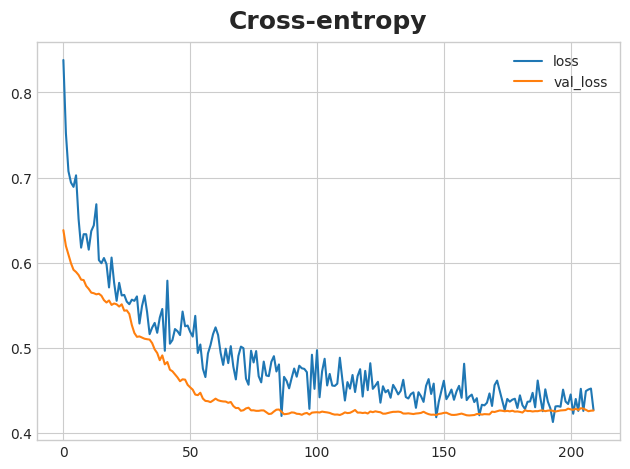

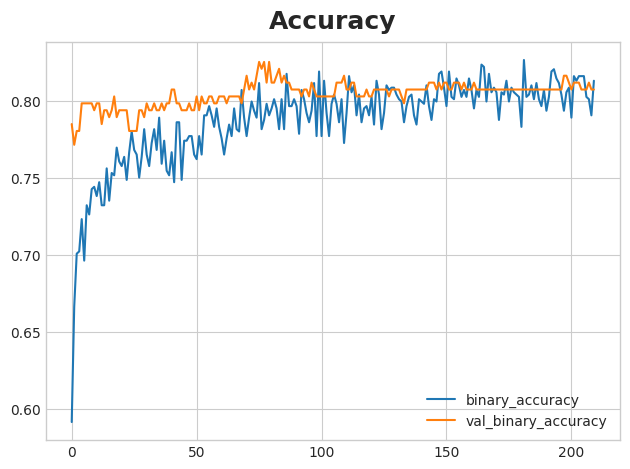

In [3]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, input_shape=input_shape, activation=keras.layers.LeakyReLU(alpha=0.3)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation=keras.layers.LeakyReLU(alpha=0.3)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation=keras.layers.LeakyReLU(alpha=0.3)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])


model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title='Accuracy')
print(f"Minimum Validation Loss: {history_df['val_loss'].min():0.4f}")
print(f"Maximum Validation Binary Accuracy: {history_df['val_binary_accuracy'].max():0.4f}")

In [4]:
predictions = model.predict(X_test)
predictions_rounded = np.round(predictions).astype(int)

output = pd.DataFrame({'PassengerId': X_test.index.values, 'Survived': predictions_rounded.flatten()})
output.to_csv('my_submission.csv', index=False)

14/14 [==============================] - 0s 2ms/step
